In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import cluster_analysis, narm_analysis, som_analysis

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['date_range'])
    # return dt_array
    return xr.where((dt_array.month>=mo_init) | (dt_array.month<=mo_end), True, False)

# 1. Get mean anoms week 1

In [3]:
path_era5_anoms = '/glade/scratch/molina/s2s/CESM2_OBS/era5_z500_anom_data.nc'
dataset_era_anoms = xr.open_dataset(path_era5_anoms)

In [4]:
# dataset_era_anoms.lon.data[dataset_era_anoms.lon.data>180] = dataset_era_anoms.lon.data[dataset_era_anoms.lon.data>180]-360

In [5]:
# slice first week lead time
dataset_era_anoms = dataset_era_anoms.where((dataset_era_anoms.lead>=0)&(dataset_era_anoms.lead<=6),drop=True)
#slice longitudes
# dataset_era_anoms = dataset_era_anoms.where((dataset_era_anoms.lon<=30)|(dataset_era_anoms.lon>=100),drop=True)
# slice latitudes
dataset_era_anoms = dataset_era_anoms.where((dataset_era_anoms.lat>=-30),drop=True)
# only cold months
cold_indx = get_cold_indx(dataset_era_anoms,10,3)
dataset_era_anoms = dataset_era_anoms.isel(time=cold_indx)
# first week anoms
anoms_week_1 = dataset_era_anoms.mean(dim='lead')

In [8]:
#reorganize data for spatial coherence

lon_new = np.roll(anoms_week_1.lon,-31)
data_new = np.roll(anoms_week_1.anom,-31,axis=2)

anoms_week_1_v2 = xr.Dataset({
             'anom': (['time','lat','lon'], anoms_week_1.anom.data),
            'date_range': (['time'], anoms_week_1.date_range[cold_indx].data),
            },
             coords =
            {'time': (['time'], anoms_week_1.time.data),
             'lat' : (['lat'], anoms_week_1.lat.data),
             'lon' : (['lon'], anoms_week_1.lon.data)
            },
            attrs = 
            {'File Author' : 'Jhayron S. Pérez-Carrasquilla',})

In [9]:
del(dataset_era_anoms)

In [10]:
path_files = '/glade/work/jhayron/Weather_Regimes/ERA5/'
anoms_week_1_v2.to_netcdf(f'{path_files}era5_z500_anoms_mean_week1.nc')

# 2. Get WR timeseries for weeks 2, 3, 4, 5

In [55]:
path_era5_anoms = '/glade/scratch/molina/s2s/CESM2_OBS/era5_z500_anom_data.nc'
dataset_era_anoms = xr.open_dataset(path_era5_anoms)

In [56]:
indices_weeks = [(7,13),
                (14,20),
                (21,27),
                (28,34)]

In [59]:
kmeans = joblib.load('/glade/work/jhayron/Weather_Regimes/models/KMeans_ERA5.mdl')
pca = joblib.load('/glade/work/jhayron/Weather_Regimes/models/PCA_ERA5.mdl')

In [85]:
for week in [2,3,4,5]:
    print(week)
    ## slice leadtime, lat, lon, and cold months
    lat0=10; lat1=70; lon0=210; lon1=320
    dataset_era_anoms_temp = dataset_era_anoms.where((dataset_era_anoms.lat>=lat0)&(dataset_era_anoms.lat<=lat1)&\
        (dataset_era_anoms.lon>=lon0)&(dataset_era_anoms.lon<=lon1)&\
        (dataset_era_anoms.lead>=indices_weeks[week-2][0])&(dataset_era_anoms.lead<=indices_weeks[week-2][1]),drop=True)
    cold_indx = get_cold_indx(dataset_era_anoms_temp,10,3)
    dataset_era_anoms_temp = dataset_era_anoms_temp.isel(time=cold_indx)

    # Mean anoms of the week
    mean_anom_week = dataset_era_anoms_temp.mean(dim='lead')

    # Flatten data
    mean_anom_week_flatten = mean_anom_week.anom.stack(flat=('lat','lon')).transpose('time','flat')

    # Apply PCA
    mean_anom_week_flatten_pca = pca.transform(mean_anom_week_flatten)

    # Apply kmeans
    serie_wr_week = kmeans.predict(mean_anom_week_flatten_pca)
    
    np.save(f'{path_files}Serie_WR_Week{week}.npy',serie_wr_week)

2
3
4
5


In [86]:
del(dataset_era_anoms_temp)
del(mean_anom_week)
del(mean_anom_week_flatten)
del(mean_anom_week_flatten_pca)

# 3. CNN week 1

In [4]:
path_files = '/glade/work/jhayron/Weather_Regimes/ERA5/'
anoms_week_1 = xr.open_dataset(f'{path_files}era5_z500_anoms_mean_week1.nc')
week = 2
serie_wr_week = np.load(f'{path_files}Serie_WR_Week{week}.npy')

In [5]:
## Reduce X size for test at Cheyenne

# anoms_week_1 = anoms_week_1.where((anoms_week_1.lat>=20)&(anoms_week_1.lat<=50)&(anoms_week_1.lon>=180)&\
#                    (anoms_week_1.lon<=-110+360),drop=True)

## 3.1 Map example

/glade/scratch/jhayron/ipykernel_70058/4222327469.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


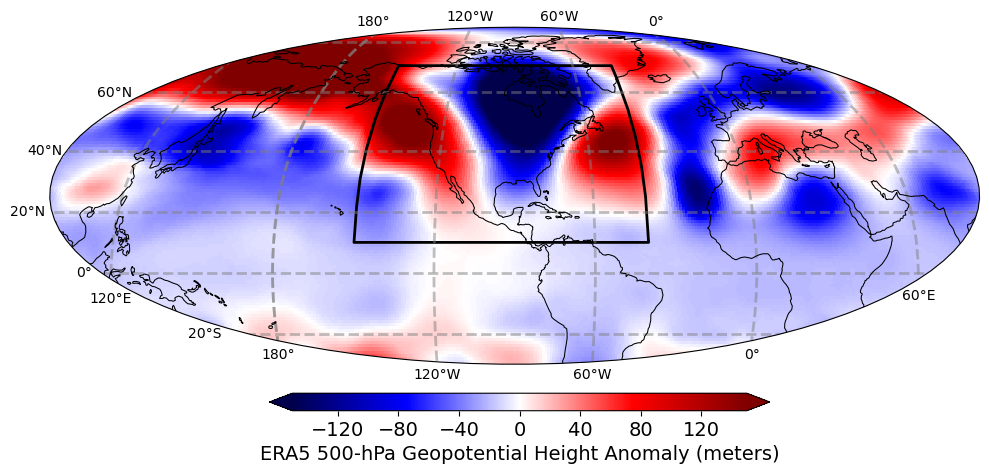

In [6]:
# ---

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=-90+360))

# ---

pm = axs.pcolormesh(anoms_week_1.lon, anoms_week_1.lat, anoms_week_1.anom[0],
                     transform=ccrs.PlateCarree(),
                     vmin=-150, vmax=150, cmap='seismic')

# axs[0][0].set_title('', 
#     fontsize=14)

axs.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
axs.margins(x=0, y=0)

axs.set_extent([-180, 180, -30, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs.set_boundary(circle, transform=axs.transAxes)

geom = geometry.box(minx=210-360, maxx=320-360, miny=10, maxy=70)
# 10-70°N, 150-40°W
axs.add_geometries([geom], crs=cartopy.crs.PlateCarree(),
                         facecolor='none', edgecolor='k', lw=2.)

axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# ---

cbar_ax = fig.add_axes([0.275, 0.285, 0.5, 0.0175])

ticks_1 = [-120,-80, -40, 0, 40, 80,120]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=14)
cbar.set_label(
    r'ERA5 500-hPa Geopotential Height Anomaly (meters)', fontsize=14)

# ---

plt.tight_layout()
# plt.savefig("fig1_wr_era5.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

## 3.2 Build CNN architecture

In [20]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import visualkeras

In [8]:
# Make Y categorical
serie_wr_categorical = to_categorical(serie_wr_week,num_classes=4)

# Scale by standard deviation
standard_deviation = anoms_week_1.anom.std(dim='time')
scaled_x = anoms_week_1.anom / standard_deviation

#Reshape X
scaled_x = scaled_x.data.reshape(-1, anoms_week_1.anom.shape[1],anoms_week_1.anom.shape[2], 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(scaled_x, serie_wr_categorical, test_size=0.2, random_state=42)

In [21]:
def create_model():
    batch_size = 64
    epochs = 50
    num_classes = 4

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',input_shape=X_train.shape[1:],padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(AveragePooling2D((3, 3),padding='same'))
    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(AveragePooling2D(pool_size=(3, 3),padding='same'))
    model.add(Conv2D(256, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))  
    model.add(AveragePooling2D(pool_size=(3, 3),padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    return model

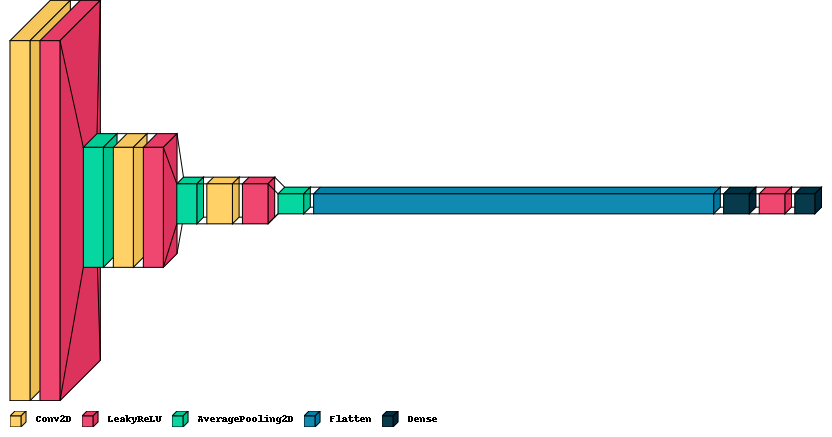

In [22]:
model = create_model()

# visualkeras.layered_view(model).show() # display using your system viewer
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
visualkeras.layered_view(model, scale_xy=1, legend=True,to_file=f'{path_figures}CNN_v0.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show



In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 121, 360, 64)      640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 121, 360, 64)      0         
                                                                 
 average_pooling2d_3 (Averag  (None, 41, 120, 64)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 41, 120, 128)      73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 41, 120, 128)      0         
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 40, 128)      0         
 ePooling2D)                                          

## Train test

In [13]:
callback = EarlyStopping(monitor='loss', patience=3)
model.fit(X_train, y_train, batch_size=batch_size,\
    epochs=epochs,verbose=1,validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/50
7/7 [==============================] - 8s 1s/step - loss: 1.4301 - accuracy: 0.2500 - val_loss: 1.3069 - val_accuracy: 0.3455
Epoch 2/50
7/7 [==============================] - 7s 1s/step - loss: 1.2758 - accuracy: 0.4174 - val_loss: 1.2849 - val_accuracy: 0.4182
Epoch 3/50
7/7 [==============================] - 7s 1s/step - loss: 1.2140 - accuracy: 0.4427 - val_loss: 1.1848 - val_accuracy: 0.4909
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 1.1033 - accuracy: 0.5206 - val_loss: 1.2595 - val_accuracy: 0.4182
Epoch 5/50
7/7 [==============================] - 7s 1s/step - loss: 1.0231 - accuracy: 0.5528 - val_loss: 1.2240 - val_accuracy: 0.4818
Epoch 6/50
7/7 [==============================] - 7s 1s/step - loss: 0.9428 - accuracy: 0.5917 - val_loss: 1.2641 - val_accuracy: 0.4909
Epoch 7/50
7/7 [==============================] - 7s 1s/step - loss: 0.8287 - accuracy: 0.6697 - val_loss: 1.3781 - val_accuracy: 0.4455
Epoch 8/50
7/7 [=========================

In [14]:
y_test_predicted = model.predict(X_test)

4/4 [==============================] - 0s 48ms/step


In [17]:
skill = 100 * len(np.where(np.argmax(y_test,axis=1) - np.argmax(y_test_predicted,axis=1) == 0)[0])/\
    len(np.argmax(y_test,axis=1))
print(f'Skill week {week}: {np.round(skill,2)}%')

Skill week 2: 52.73%


# 4. Train CNN for each week

In [4]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import visualkeras

2022-09-26 10:51:52.297852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 10:51:52.783796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/ch/opt/mpt_fmods/2.25/intel/19.1.1:/glade/u/apps/ch/opt/mpt/2.25/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64:/glade/u/apps/ch/os/usr/lib64:/glade/u/apps/ch/os/usr/lib:/glade/u/apps/ch/os/lib64:/glade/u/apps/ch/os/lib
2022-09-26 10:51:52.783824: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on yo

In [5]:
def create_model():
    batch_size = 64
    epochs = 50
    num_classes = 4

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',input_shape=X_train.shape[1:],padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(AveragePooling2D((3, 3),padding='same'))
    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(AveragePooling2D(pool_size=(3, 3),padding='same'))
    model.add(Conv2D(256, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))  
    model.add(AveragePooling2D(pool_size=(3, 3),padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    return model

In [6]:
path_models_cnn = '/glade/work/jhayron/Weather_Regimes/models/CNN/'
path_files = '/glade/work/jhayron/Weather_Regimes/ERA5/'
anoms_week_1 = xr.open_dataset(f'{path_files}era5_z500_anoms_mean_week1.nc')

In [ ]:
skills = []
for week in [2,3,4,5]:
    # Load weather regimes time series
    serie_wr_week = np.load(f'{path_files}Serie_WR_Week{week}.npy')
    
    # Make Y categorical
    serie_wr_categorical = to_categorical(serie_wr_week,num_classes=4)

    # Scale by standard deviation
    standard_deviation = anoms_week_1.anom.std(dim='time')
    scaled_x = anoms_week_1.anom / standard_deviation

    #Reshape X
    scaled_x = scaled_x.data.reshape(-1, anoms_week_1.anom.shape[1],anoms_week_1.anom.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(scaled_x, serie_wr_categorical, test_size=0.2, random_state=42)

    # Create empty model
    model = create_model()
    
    # Train
    callback = EarlyStopping(monitor='loss', patience=3)
    batch_size = 64
    epochs = 50
    history = model.fit(X_train, y_train, batch_size=batch_size,\
        epochs=epochs,verbose=0,validation_data=(X_test, y_test), callbacks=[callback])
    model.save(f'{path_models_cnn}CNN_v0_week{week}.h5')
    joblib.dump(model,f'{path_models_cnn}CNN_v0_week{week}.history')
    
    # Test
    y_test_predicted = model.predict(X_test)
    skill = 100 * len(np.where(np.argmax(y_test,axis=1) - np.argmax(y_test_predicted,axis=1) == 0)[0])/\
        len(np.argmax(y_test,axis=1))
    skills.append(skill)
    print(f'Skill week {week}: {np.round(skill,2)}%')
    

2022-09-26 10:52:12.133483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/ch/opt/mpt_fmods/2.25/intel/19.1.1:/glade/u/apps/ch/opt/mpt/2.25/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64:/glade/u/apps/ch/os/usr/lib64:/glade/u/apps/ch/os/usr/lib:/glade/u/apps/ch/os/lib64:/glade/u/apps/ch/os/lib
2022-09-26 10:52:12.133527: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-26 10:52:12.133558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cheyenne2): /proc/driver/nvidia/version does not exist
2022-09-26 10:52:12.133917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use 

INFO:tensorflow:Assets written to: ram://55e9da72-3337-4bd5-a899-d87e203fb976/assets


INFO:tensorflow:Assets written to: ram://55e9da72-3337-4bd5-a899-d87e203fb976/assets


4/4 [==============================] - 0s 46ms/step
Skill week 2: 43.64%


INFO:tensorflow:Assets written to: ram://da7e968f-2b58-417b-9b01-2d57d2fd77c7/assets


INFO:tensorflow:Assets written to: ram://da7e968f-2b58-417b-9b01-2d57d2fd77c7/assets


4/4 [==============================] - 0s 45ms/step
Skill week 3: 30.91%


INFO:tensorflow:Assets written to: ram://ec720b95-2598-4231-86c1-5856e70c6184/assets


INFO:tensorflow:Assets written to: ram://ec720b95-2598-4231-86c1-5856e70c6184/assets


4/4 [==============================] - 0s 47ms/step
Skill week 4: 29.09%


# 4. Check and compare with persistence

## 4.1 Test trained models

In [8]:
from keras.models import load_model

In [31]:
skills = []
for week in [2,3,4,5]:
    # Load weather regimes time series
    serie_wr_week = np.load(f'{path_files}Serie_WR_Week{week}.npy')
    
    # Make Y categorical
    serie_wr_categorical = to_categorical(serie_wr_week,num_classes=4)

    # Scale by standard deviation
    standard_deviation = anoms_week_1.anom.std(dim='time')
    scaled_x = anoms_week_1.anom / standard_deviation

    #Reshape X
    scaled_x = scaled_x.data.reshape(-1, anoms_week_1.anom.shape[1],anoms_week_1.anom.shape[2], 1)

    X_train, X_test, y_train, y_test = train_test_split(scaled_x, serie_wr_categorical, test_size=0.2, random_state=42)

    # Create empty model
    model = load_model(f'{path_models_cnn}CNN_v0_week{week}.h5')
    joblib.dump(model,f'{path_models_cnn}CNN_v0_week{week}.history')
    
    # Test
    y_test_predicted = model.predict(X_test)
    skill = 100 * len(np.where(np.argmax(y_test,axis=1) - np.argmax(y_test_predicted,axis=1) == 0)[0])/\
        len(np.argmax(y_test,axis=1))
    skills.append(skill)
    print(f'Skill week {week}: {np.round(skill,2)}%')
    

INFO:tensorflow:Assets written to: ram://b2a4172e-9c70-44d3-9bcb-5b252871ecba/assets


INFO:tensorflow:Assets written to: ram://b2a4172e-9c70-44d3-9bcb-5b252871ecba/assets


4/4 [==============================] - 0s 45ms/step
Skill week 2: 43.64%


INFO:tensorflow:Assets written to: ram://ac49cb87-b140-4689-b0d9-e53062c005c9/assets


INFO:tensorflow:Assets written to: ram://ac49cb87-b140-4689-b0d9-e53062c005c9/assets


4/4 [==============================] - 0s 45ms/step
Skill week 3: 30.91%


INFO:tensorflow:Assets written to: ram://98f4e706-a095-4e3e-9ba7-be020d12a91f/assets


INFO:tensorflow:Assets written to: ram://98f4e706-a095-4e3e-9ba7-be020d12a91f/assets


4/4 [==============================] - 0s 45ms/step
Skill week 4: 29.09%


INFO:tensorflow:Assets written to: ram://a230f5d9-ff82-451f-a86c-d8ed052d28cc/assets


INFO:tensorflow:Assets written to: ram://a230f5d9-ff82-451f-a86c-d8ed052d28cc/assets


4/4 [==============================] - 0s 44ms/step
Skill week 5: 30.0%


## 4.2 Persistence

### 4.2.1 Get WR for week 1

In [33]:
path_era5_anoms = '/glade/scratch/molina/s2s/CESM2_OBS/era5_z500_anom_data.nc'
dataset_era_anoms = xr.open_dataset(path_era5_anoms)

In [34]:
indices_week_1 = (0,6)

In [35]:
kmeans = joblib.load('/glade/work/jhayron/Weather_Regimes/models/KMeans_ERA5.mdl')
pca = joblib.load('/glade/work/jhayron/Weather_Regimes/models/PCA_ERA5.mdl')

In [36]:
week = 1
## slice leadtime, lat, lon, and cold months
lat0=10; lat1=70; lon0=210; lon1=320
dataset_era_anoms_temp = dataset_era_anoms.where((dataset_era_anoms.lat>=lat0)&(dataset_era_anoms.lat<=lat1)&\
    (dataset_era_anoms.lon>=lon0)&(dataset_era_anoms.lon<=lon1)&\
    (dataset_era_anoms.lead>=indices_week_1[0])&(dataset_era_anoms.lead<=indices_week_1[1]),drop=True)
cold_indx = get_cold_indx(dataset_era_anoms_temp,10,3)
dataset_era_anoms_temp = dataset_era_anoms_temp.isel(time=cold_indx)

# Mean anoms of the week
mean_anom_week = dataset_era_anoms_temp.mean(dim='lead')

# Flatten data
mean_anom_week_flatten = mean_anom_week.anom.stack(flat=('lat','lon')).transpose('time','flat')

# Apply PCA
mean_anom_week_flatten_pca = pca.transform(mean_anom_week_flatten)

# Apply kmeans
serie_wr_week = kmeans.predict(mean_anom_week_flatten_pca)

np.save(f'{path_files}Serie_WR_Week{week}.npy',serie_wr_week)

In [37]:
del(dataset_era_anoms_temp)
del(mean_anom_week)
del(mean_anom_week_flatten)
del(mean_anom_week_flatten_pca)

## 4.2.2 Compute persistence skill and compare

In [48]:
skills_persistence = []
for week in [2,3,4,5]:
    # Load weather regimes time series
    serie_wr_week = np.load(f'{path_files}Serie_WR_Week{week}.npy')
    
    # Make Y categorical
    serie_wr_categorical = to_categorical(serie_wr_week,num_classes=4)

    # Scale by standard deviation
    standard_deviation = anoms_week_1.anom.std(dim='time')
    scaled_x = anoms_week_1.anom / standard_deviation

    #Reshape X
    scaled_x = scaled_x.data.reshape(-1, anoms_week_1.anom.shape[1],anoms_week_1.anom.shape[2], 1)
    
    serie_wr_categorical_persistence = np.load(f'{path_files}Serie_WR_Week{1}.npy')
    serie_wr_categorical_persistence = to_categorical(serie_wr_categorical_persistence,num_classes=4)
    
    X_train, X_test, y_train, y_test = train_test_split(scaled_x, serie_wr_categorical, test_size=0.2, random_state=42)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_x, serie_wr_categorical_persistence, \
                                                            test_size=0.2, random_state=42)

    y_test_predicted = y_test2
    skill = 100 * len(np.where(np.argmax(y_test,axis=1) - np.argmax(y_test_predicted,axis=1) == 0)[0])/\
        len(np.argmax(y_test,axis=1))
    skills_persistence.append(skill)
    print(f'Skill week {week}: {np.round(skill,2)}%')
    

Skill week 2: 41.82%
Skill week 3: 28.18%
Skill week 4: 31.82%
Skill week 5: 25.45%


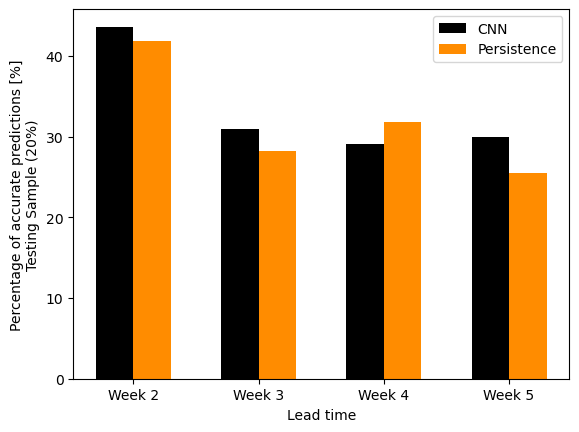

In [69]:
plt.bar(np.arange(4),skills,width=-0.3,align='edge',label='CNN',color='k')
plt.bar(np.arange(4),skills_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
plt.legend()
plt.ylabel('Percentage of accurate predictions [%]\nTesting Sample (20%)')
plt.xticks(np.arange(4),['Week 2','Week 3','Week 4','Week 5'])
plt.xlabel('Lead time')
path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/'
plt.savefig(f'{path_figures}Skill_CNNv0vsPersistence.png',bbox_inches='tight')

